In [1]:
import sys
sys.path.append("../../dataprocessing")
import numpy as np
import os
import PIL
import PIL.Image
from PIL import ImageDraw
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm
import random
import data_process
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.spatial import distance
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

## 함수 정의

In [2]:
cd ../

c:\Users\jongm\Desktop\MINI\projects\Facial-Expression-Recognition\modeling


In [3]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        # if data.columns[idx] == 'frame':
        #     continue
        if data.columns[idx][:-1] in target_landmark:
            # print(x,y)
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        else:
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [4]:
def show_diff(*args):
    data = args[0]
    window = args[1]
    erase_list = ['frame','left','top','right','bottom','time_diff']
    data3 = data[[point for point in data.columns if '-' in point] + erase_list]

    if len(args) == 3:
        idxs = args[2]
        i = 0
        for idx in idxs:
            if i == 0:
                data2 = data[[point for point in data.columns if str(idx) == point.split('-')[0]]]
            else:
                data2 = pd.concat([data2, data[[point for point in data.columns if str(idx) == point.split('-')[0]]]], axis=1)
            i += 1
        data2 = pd.concat([data2, data[erase_list]], axis=1)
        # print(data2.columns)
    else:
        data2 = data3.copy()

    # print(list(set(data.columns) - set(erase_list)))
    remain_list = sorted(list(set(data2.columns) - set(erase_list)))
    diff_df = pd.DataFrame(columns=list(range(len(data2))), index=list(set([c[:-1] for c in remain_list])))

    # print(data2, remain_list)    
    for row in range(0, len(remain_list), 2):
        init_point = [data2.iloc[0][remain_list[row]], data2.iloc[0][remain_list[row+1]]]
        # print(remain_list[col], remain_list[col+1])
        temp2 = 0.0
        # diff_df[remain_list[col][:-1]] = 0
        for col in range(len(data2)):    
            # print(init_point, data.loc[col][remain_list[row]], data.loc[col][remain_list[row+1]])    
            temp = distance.euclidean(init_point, [data2.loc[col][remain_list[row]], data2.loc[col][remain_list[row+1]]])
            temp2 += temp
            # for start in range(0,len(data.index), window):
            #     # print(max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col]), max(data.iloc[start:start+5][col]), min(data.iloc[start:start+5][col]))
            #     temp += max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col])
            diff_df.at[remain_list[row][:-1], col] = temp
        diff_df.at[remain_list[row][:-1], 'sum'] = temp2
        # print(remain_list[col] + ", "+ remain_list[col+1])
    return diff_df.sort_values('sum', ascending=False), data3

In [50]:
def make_flow_chart(data, diff_df, part, order, image_order, path):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (20,10))
    # sort = diff_df.iloc[:order]
    # print(diff_df)
    if type(order) == int:        
        diff_df = diff_df.drop(['sum'], axis=1)
        new_data = diff_df.iloc[:order]
    elif type(order) == list:
        diff_df = diff_df.drop(['class'], axis=1)
        new_data = diff_df[order]
        new_data = new_data.transpose()
    print(new_data.index)
    # new_data = new_data[[point for point in new_data.columns if str(part) == point.split('-')[0]]]
    temp_plot = sns.lineplot(data = new_data.transpose(), markers=False, dashes=False)  
    # print(path+str(image_order) + '.0.jpg')
    show_img(data, path + str(image_order) + '.0.jpg', new_data)
    # ax[idx, col].set_title(str(idx) +" 번 클러스터")
    # if col==0:        
    #     ax[idx, col].set_ylabel(list(custom_sort.keys())[idx])
    #     ax[idx, col].yaxis.label.set_size(20)
    # ax[idx].set_ylabel(list(custom_sort.keys())[idx] + " group")
    # ax[idx].set_xticks(list(range(1,len(seq)+1)))        
    # for row in data.iterrows():
    #     ax[idx].text(row[0], int(row[1]['quiz']), int(row[1]['quiz']), fontsize=12, ha='center') 
    #     ax[idx].text(row[0], int(row[1]['proj']), int(row[1]['proj']), fontsize=12, ha='center')

> 0은 얼굴 테두리 \
> 1, 2는 왼쪽 눈썹 위, 아래 \
> 3, 4는 오른쪽 눈썹 위, 아래 \
> 5, 6은 왼쪽, 오른쪽 눈 \
> 7, 8은 위쪽 입술 윗부분, 아래부분 \
> 9, 10은 아래쪽 입술 윗부분, 아래부분 \
> 11은 코 세로축 \
> 12는 코 아래부분

## 1. 눈썹 들어올리기

## 3. 두 눈 감기

In [55]:
landmarks = pd.read_csv('../data/images/202209.03105902855+0/202209.03105902855.csv')
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = diff_list.drop(['sum'], axis=1)
diff_list = diff_list.transpose()
diff_list['class'] = 0
landmarks = pd.read_csv('../data/images/202209.03105914019+1/202209.03105914019.csv')
diff_list2, landmarks_cut = show_diff(landmarks, 5)
diff_list2 = diff_list2.drop(['sum'], axis=1)
diff_list2 = diff_list2.transpose()
diff_list2['class'] = 1
df = pd.concat([diff_list, diff_list2], axis=0)

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

### rf

[[ 8  4]
 [ 0 11]]
훈련세트 정확도: 0.989
테스트세트 정확도: 0.826


<AxesSubplot:xlabel='importance', ylabel='landmarks'>

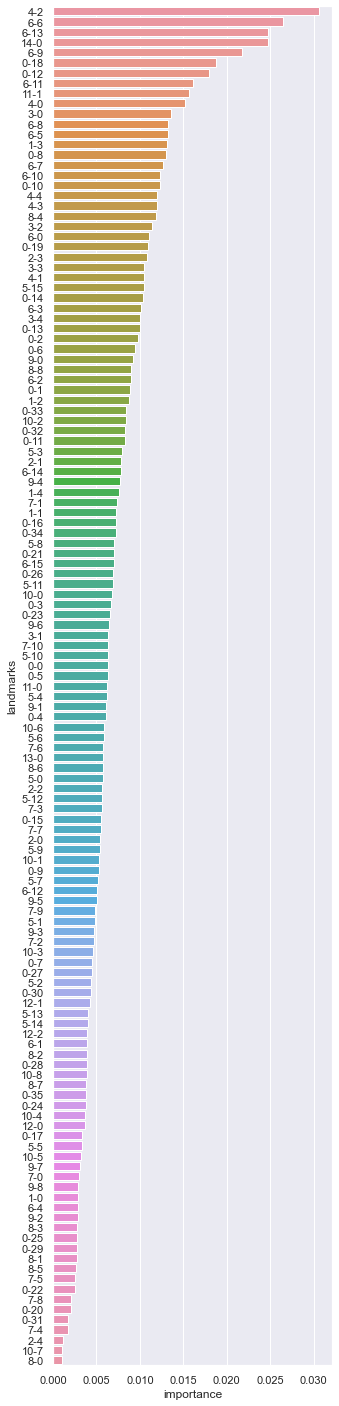

In [56]:
rand_clf = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=2022, oob_score=True)

rand_clf.fit(X_train, y_train)
pred = rand_clf.predict(X_test)
print(confusion_matrix(y_test, pred))
# accuracy = accuracy_score(y_test, pred)
# print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))
print('훈련세트 정확도: {:.3f}' .format(rand_clf.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rand_clf.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': X.columns, 'importance': rand_clf.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
sns.set(rc = {'figure.figsize':(5,25)})
sns.barplot(x=importance.importance , y=importance.landmarks)

Index(['4-2', '6-6', '6-13', '14-0', '6-9'], dtype='object')


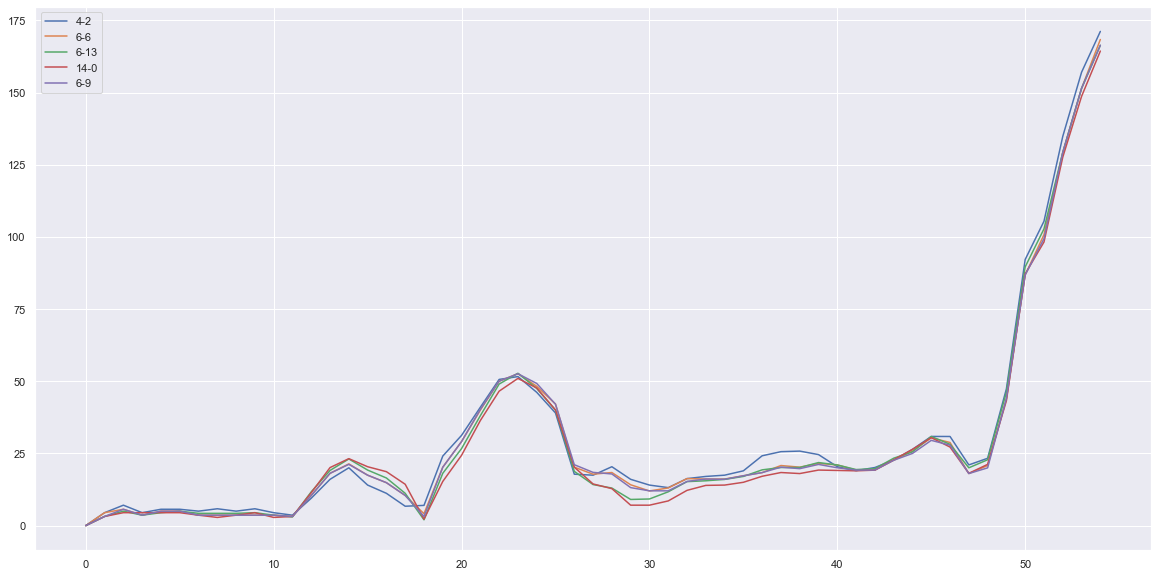

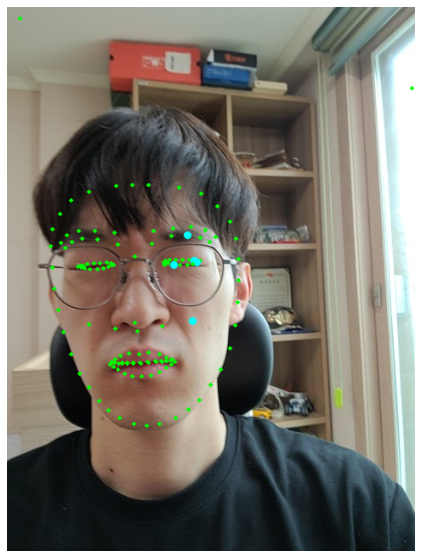

In [57]:
face = '202209.03105914019+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

### xgboost

[[ 8  4]
 [ 0 11]]
훈련세트 정확도: 0.967
테스트세트 정확도: 0.826


<AxesSubplot:xlabel='importance', ylabel='landmarks'>

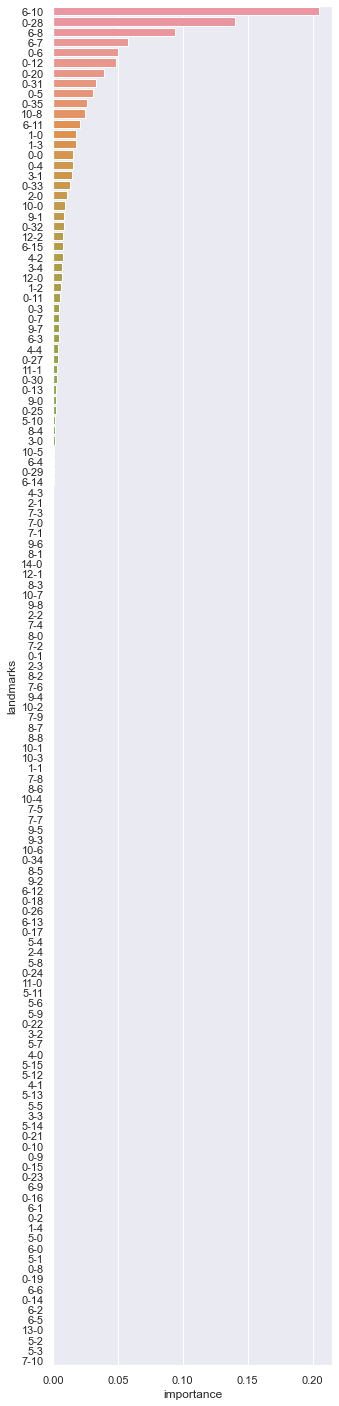

In [58]:
model = XGBClassifier(use_label_encoder=False,
                        eval_metric='mlogloss')
hist = model.fit(X_train, y_train)
pred = rand_clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print('훈련세트 정확도: {:.3f}' .format(model.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(model.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': X_train.columns, 'importance': model.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
sns.set(rc = {'figure.figsize':(5,25)})
sns.barplot(x=importance.importance , y=importance.landmarks)

Index(['6-10', '0-28', '6-8', '6-7', '0-6'], dtype='object')


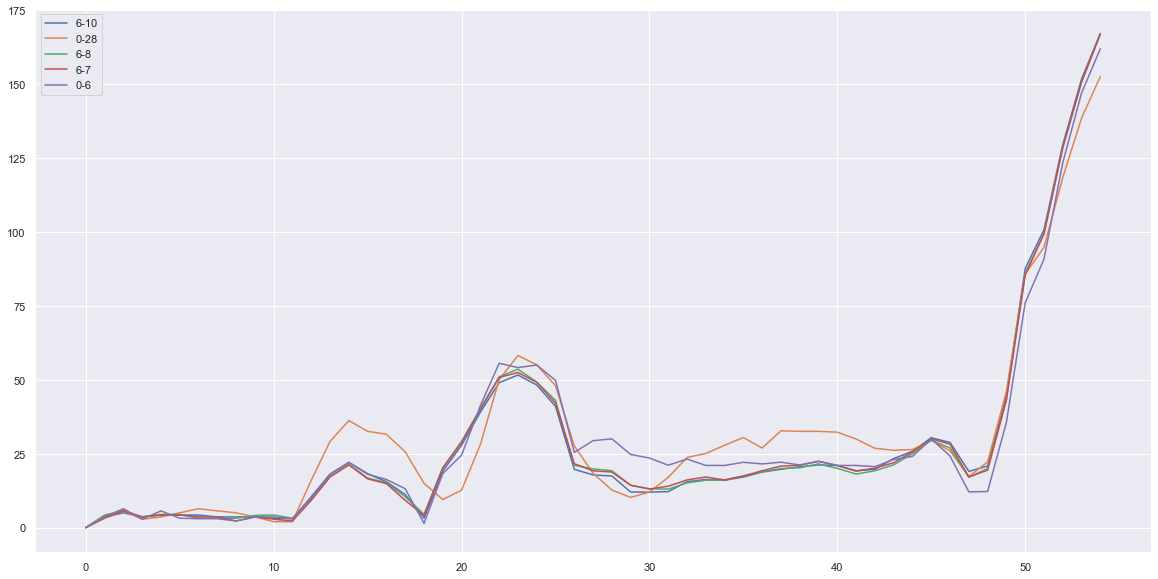

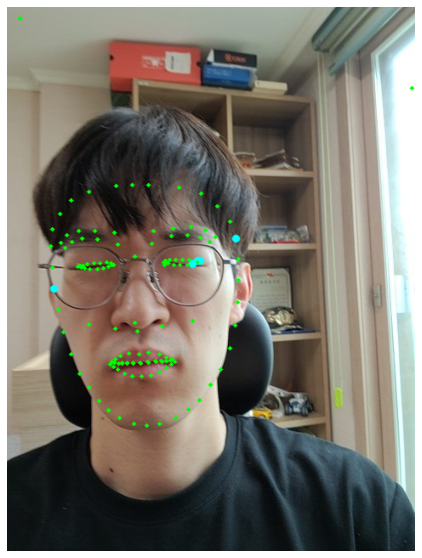

In [59]:
face = '202209.03105914019+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 4. 두 눈 크게 뜨기

Index(['3-2', '3-3', '4-2', '1-3', '4-1', '3-4', '1-4', '4-3', '3-1', '0-2'], dtype='object')


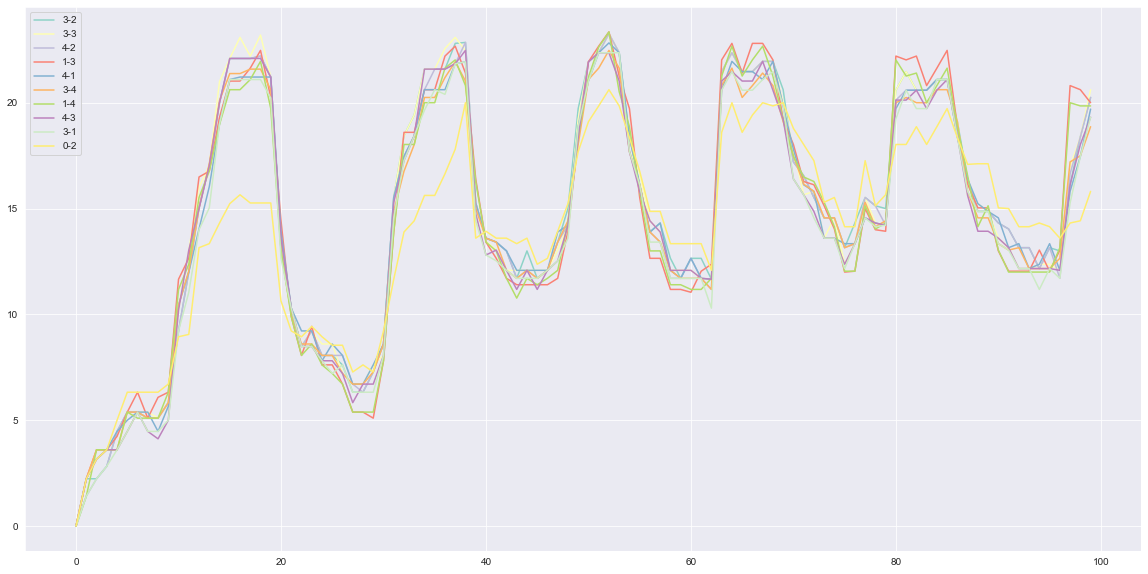

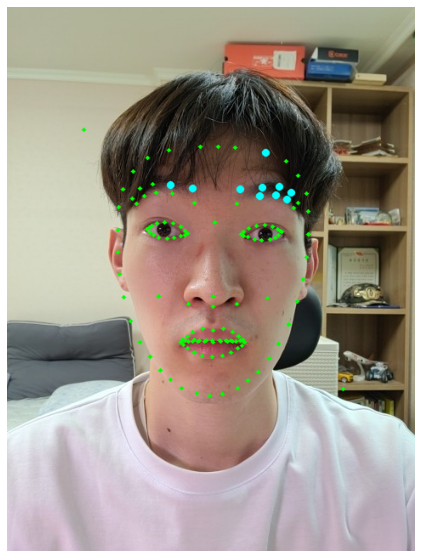

In [228]:
face = '두눈크게뜨기'
landmarks = pd.read_csv('../data/images/'+face+'/202208.20172106650.csv')
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 7,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 9. 입벌리기

Index(['11-1', '12-1', '7-4', '12-2', '7-6', '4-3', '7-3', '12-0', '3-4',
       '7-5'],
      dtype='object')


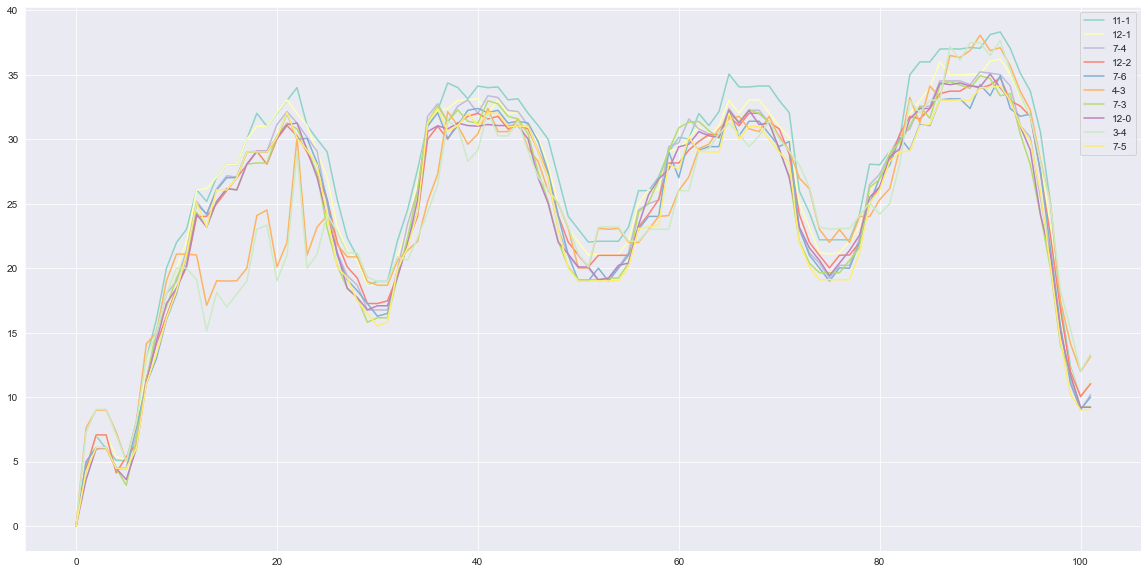

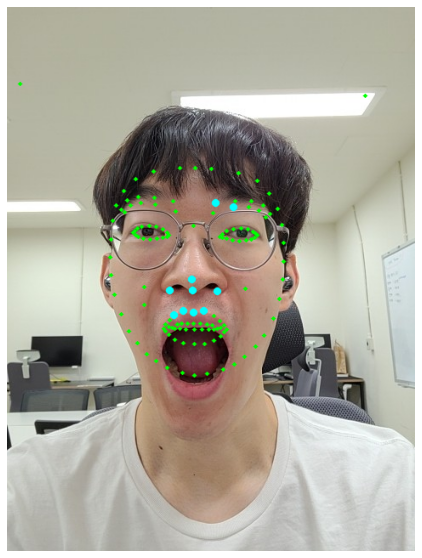

In [14]:
face = '입벌리기'
landmarks = pd.read_csv('../data/images/'+face+'/202208.23122709306.csv')
diff_list, landmarks_cut = show_diff(landmarks, 5)
make_flow_chart(part= 1, order = 10, image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

Index(['7-4', '7-6', '7-3', '7-5', '8-4', '8-5', '8-2', '7-2', '7-7', '7-8',
       '8-3', '8-6', '8-1', '7-1', '8-7', '7-9', '7-0', '7-10', '8-0', '8-8',
       '10-8', '10-0', '10-7', '9-8', '10-1', '9-0', '10-2', '10-6', '9-7',
       '10-3', '9-1', '10-5', '9-2', '9-5', '9-6', '9-3', '10-4', '9-4'],
      dtype='object')


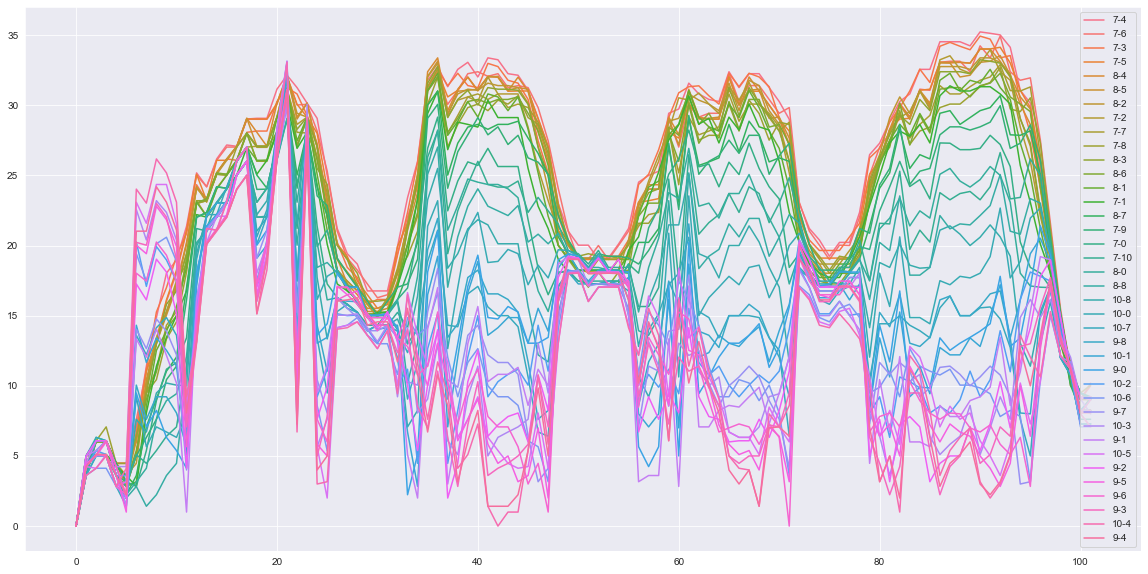

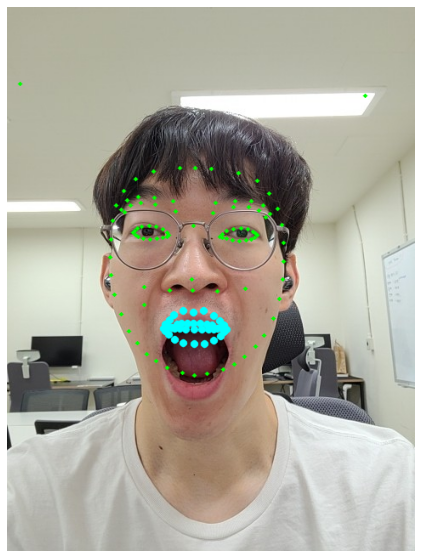

In [17]:
diff_list, landmarks_cut = show_diff(landmarks, 5, [7,8,9,10])
make_flow_chart(part= 1, order = 40, image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

> 입 크게 벌리니까 landmark 인식을 제대로 못함

## 10. 입술 오므리기

In [207]:
diff_list

0         1         2         3         4         5          6  \
11-1  0.0  4.472136       7.0       6.0   5.09902   5.09902   8.062258   
12-1  0.0  4.472136       7.0  7.071068  5.385165   5.09902   7.071068   
7-4   0.0       5.0  6.082763  6.082763  4.472136  4.472136   7.071068   
12-2  0.0  4.472136  7.071068  7.071068  4.123106  5.385165   6.324555   
7-6   0.0       5.0  6.082763  6.082763  4.472136  4.472136   7.615773   
...   ...       ...       ...       ...       ...       ...        ...   
9-5   0.0  4.472136       5.0       6.0  3.605551       1.0  20.024984   
9-6   0.0  4.242641   5.09902       5.0  2.828427  2.236068  18.027756   
9-3   0.0  4.242641   5.09902  6.082763  4.242641  2.236068  20.223748   
10-4  0.0  3.605551  4.123106       5.0  2.828427  4.123106  24.020824   
9-4   0.0  4.242641   5.09902   5.09902  3.605551  2.236068  21.023796   

              7          8          9  ...         93         94         95  \
11-1       13.0   16.03122       20.0  ...  37.054015  35.128336  33.734256   
12-1       13.0  15.033296  18.027756  ...  35.057096   33.24154  31.780497   
7-4   11.401754  14.866069  18.027756  ...  34.132096  31.064449  30.149627   
12-2  11.401754  14.142136  16.278821  ...  32.984845  32.572995  31.780497   
7-6   11.045361       13.0   16.03122  ...  32.388269  31.780497  31.953091   
...         ...        ...        ...  ...        ...        ...        ...   
9-5   19.416488  22.803509   21.84033  ...   4.472136  10.049876   6.403124   
9-6   17.464249  20.248457  19.313208  ...    5.09902   6.324555   2.828427   
9-3   20.024984       23.0  22.022716  ...   6.403124  12.806248       13.0   
10-4  23.021729  26.172505  25.179357  ...        5.0  13.601471  12.041595   
9-4   21.023796  24.186773  23.086793  ...    5.09902  12.649111       10.0   

             96         97         98         99        100        101  \
11-1  30.594117  25.079872  17.262677  12.369317       10.0   11.18034   
12-1  28.635642  23.194827  16.278821  12.165525       10.0   11.18034   
7-4   25.495098  21.095023  15.132746  11.401754        9.0  10.198039   
12-2  27.513633  22.561028  16.763055       12.0  10.049876  11.045361   
7-6   27.513633  21.587033  15.524175  11.045361   9.055385       10.0   
...         ...        ...        ...        ...        ...        ...   
9-5        13.0  17.117243  13.152946  11.401754   9.055385   9.219544   
9-6   12.649111  17.117243  13.038405  11.401754   8.062258   8.246211   
9-3   15.620499  17.720045  13.601471  11.045361   8.062258        9.0   
10-4  10.630146  15.297059  12.165525   11.18034        8.0   7.071068   
9-4   13.601471  17.464249  13.341664   11.18034   8.062258   8.062258   

              sum  
11-1  2717.354554  
12-1  2618.090733  
7-4   2529.596296  
12-2  2506.619874  
7-6   2478.467240  
...           ...  
9-5   1223.090920  
9-6   1215.924307  
9-3   1197.440073  
10-4  1167.237352  
9-4   1164.918326  

[133 rows x 103 columns]

In [242]:
landmarks

frame    top  bottom   left  right   0-0x   0-0y   0-1x   0-1y   0-2x  \
0      0.0  220.0   481.0   97.0  353.0  219.0  252.0  236.0  253.0  268.0   
1      1.0  219.0   475.0   97.0  353.0  219.0  244.0  237.0  245.0  268.0   
2      2.0  223.0   475.0  101.0  353.0  220.0  244.0  238.0  244.0  269.0   
3      3.0  223.0   475.0  101.0  353.0  220.0  244.0  238.0  244.0  269.0   
4      4.0  220.0   476.0   99.0  356.0  221.0  244.0  238.0  244.0  270.0   
..     ...    ...     ...    ...    ...    ...    ...    ...    ...    ...   
173  173.0  210.0   470.0   92.0  353.0  220.0  234.0  238.0  235.0  269.0   
174  174.0  210.0   470.0   92.0  353.0  221.0  233.0  239.0  234.0  270.0   
175  175.0  210.0   470.0   92.0  353.0  221.0  233.0  239.0  234.0  270.0   
176  176.0  212.0   468.0   92.0  348.0  218.0  233.0  236.0  234.0  267.0   
177  177.0  208.0   468.0   83.0  347.0  212.0  231.0  230.0  232.0  261.0   

     ...          6y          7x          7y          9x          9y  \
0    ...  378.885010  289.520203  392.618897  327.125214  363.726410   
1    ...  372.286285  291.716644  386.177429  328.763428  354.727966   
2    ...  371.950317  293.183441  384.722870  328.504730  356.808014   
3    ...  371.790680  292.513794  384.851196  329.487030  353.063751   
4    ...  373.299194  293.089142  386.152710  330.020019  358.241394   
..   ...         ...         ...         ...         ...         ...   
173  ...  365.096954  290.628540  380.918060  326.376434  347.494568   
174  ...  366.019318  290.850067  381.853882  326.399872  348.981018   
175  ...  365.930389  292.166809  380.488464  327.570587  346.988556   
176  ...  368.024506  287.134644  382.662445  321.633392  347.612793   
177  ...  364.735230  282.653809  378.490051  318.855194  347.996277   

            10x         10y         11x         11y  time_diff  
0    270.316132  325.566650  261.609314  434.875397          0  
1    272.242493  319.161743  261.578125  428.263031         80  
2    273.555298  317.862335  262.780090  427.921417         79  
3    273.990540  317.715118  261.537720  428.125702         81  
4    273.886780  319.359894  262.778381  429.576599         87  
..          ...         ...         ...         ...        ...  
173  271.788361  312.500610  258.779999  423.001068         86  
174  272.165680  313.381683  260.891449  422.448975         78  
175  272.151459  312.039551  263.802765  422.239044         84  
176  267.342651  314.049377  260.656433  423.907074         85  
177  262.634735  310.582703  256.831116  420.060242         78  

[178 rows x 292 columns]

Index(['0-30', '0-29', '0-31', '0-27', '0-32', '0-28', '0-33', '0-25', '1-0',
       '0-26'],
      dtype='object')


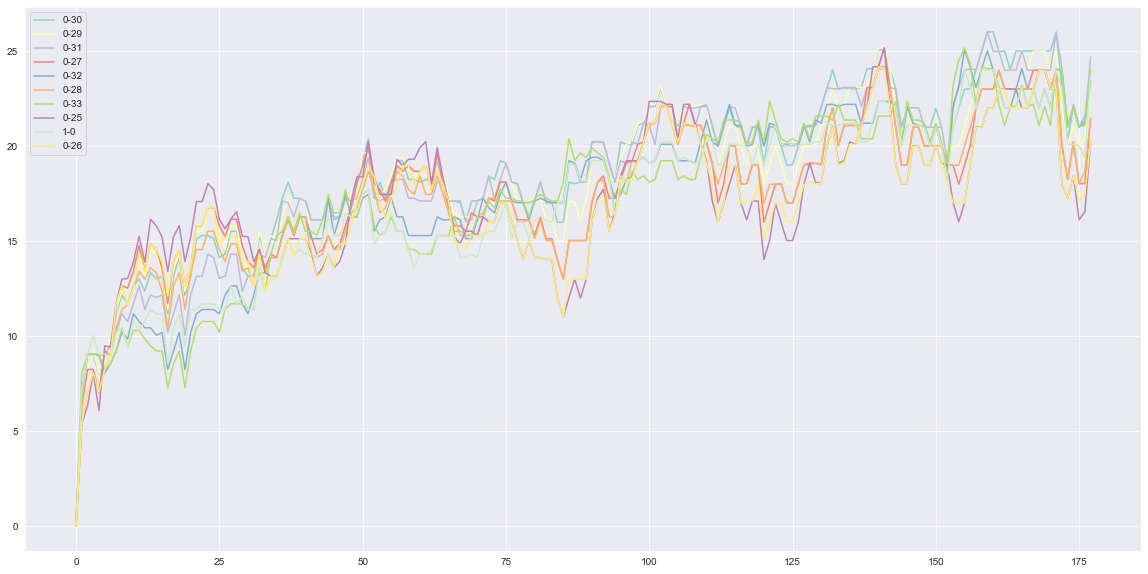

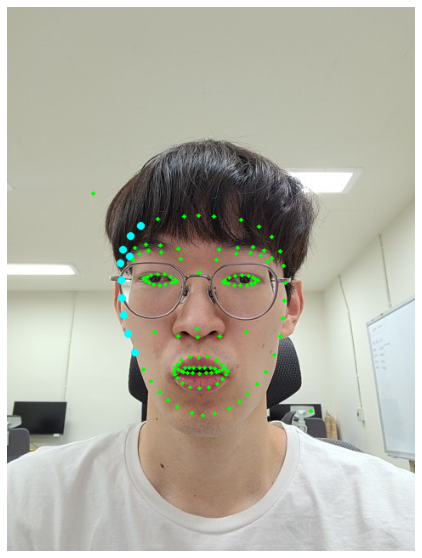

In [241]:
face = '입술오므리기2'
landmarks = pd.read_csv('../data/images/'+face+'/202208.23143251488.csv')
landmarks = landmarks.dropna()
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 10,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 16. 미소짓기

Index(['7-1', '7-0', '7-2', '8-0', '8-1', '8-2', '7-9', '10-8', '7-10', '7-3'], dtype='object')


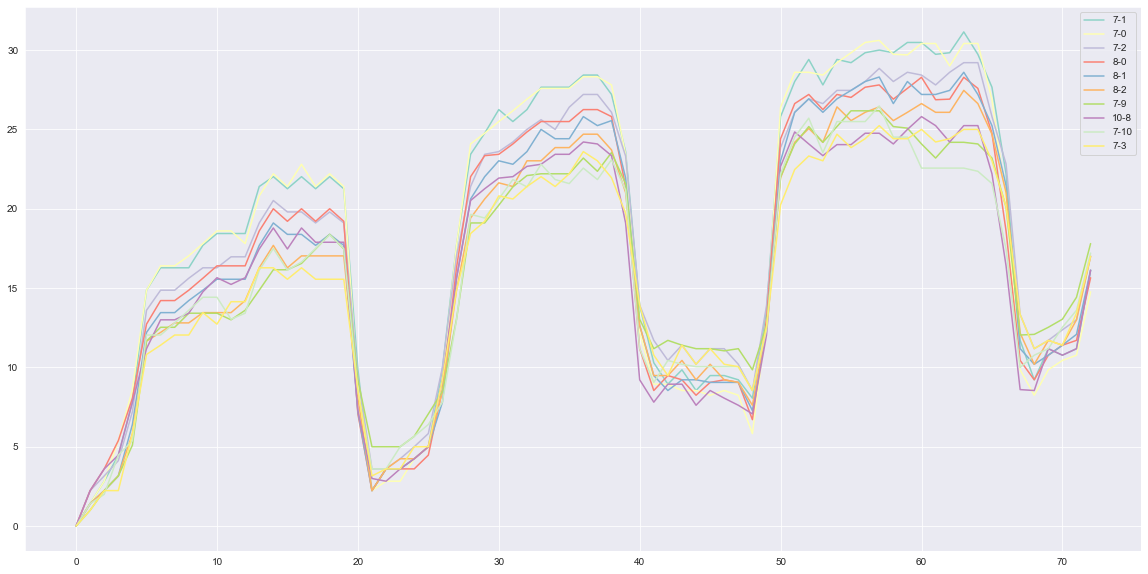

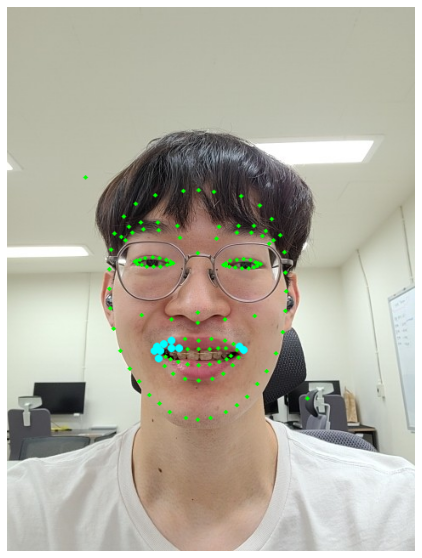

In [232]:
face = '미소짓기'
landmarks = pd.read_csv('../data/images/'+face+'/202208.23122804433.csv')
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 13,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)